# Data Loading

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display

%matplotlib inline

data = pd.read_csv("data_without_labels.csv")
print("Data shape:", data.shape)

('Data shape:', (286048, 12))


In [2]:
del data['Labels']

In [3]:
display(data.describe())

,Observation_ID,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Labels
count,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000,286048.000000
mean,143024.500000,2914.242610,151.917224,13.598309,278.255251,45.839107,2414.978643,213.983685,225.246605,142.680092,2155.583857,0.009603
std,82575.089238,197.987324,107.488551,7.138464,210.458091,57.504597,1618.090012,24.955931,18.551910,36.501454,1423.976520,0.097525
min,1.000000,1988.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,71512.750000,2788.000000,60.000000,8.000000,120.000000,8.000000,1123.000000,201.000000,215.000000,120.000000,1165.000000,0.000000
50%,143024.500000,2933.000000,126.000000,13.000000,240.000000,30.000000,2016.000000,219.000000,227.000000,142.000000,1832.000000,0.000000
75%,214536.250000,3041.000000,241.000000,18.000000,390.000000,67.000000,3386.000000,232.000000,239.000000,167.000000,2647.000000,0.000000
max,286048.000000,3433.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,1.000000


Based on domain knowledge and the problem description, "Elevation" shall be the most important feature to first consider

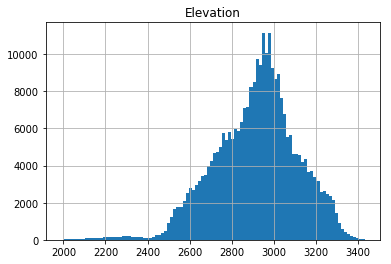

In [5]:
pd.DataFrame.hist(data, column='Elevation', bins=100);

Based on domain knowledge of lodgepole pine and cottonwood/willow, most of the tail on the left shall correspond to cottonwood/willow. So let's first apply clustering to "Elevation" with 2 classes to see what we can get

In [6]:
from sklearn.mixture import GaussianMixture
elevations = data['Elevation'].values.reshape(-1, 1)
clusterer = GaussianMixture(n_components=2).fit(elevations)

In [7]:
preds = clusterer.predict(elevations)
centers = clusterer.means_
print(centers)

[[ 2763.38240831]
 [ 3002.05909252]]


From the values of the two centers, we can see the clustering does not work well on detecting the left tail. Next, let us simply separate the outliers for further analysis

In [8]:
def mad_based_outlier(points, thresh=2.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [10]:
masks = mad_based_outlier(elevations)
print(sum(masks))

4497


If we know about one percent are cottonwood/willows, which is about 2800, then we can try adjust thresh in mad_based_outlier to get an initial result

In [11]:
masks = mad_based_outlier(elevations, thresh=3.2)
print(sum(masks))
data['Predicted_Labels'] = masks
inital_predictions = data[['Observation_ID', 'Predicted_Labels']]
inital_predictions.to_csv('data_with_predicted_labels_v1.csv')

2851


Now let's consider more points on the left tail

In [12]:
masks = mad_based_outlier(elevations, thresh=2.5)
print(sum(masks))
reduced_data = data[masks]
print reduced_data.shape

4497
(4497, 13)


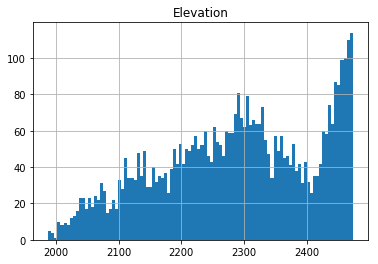

In [13]:
reduced_data = reduced_data[reduced_data['Elevation'] < 3000] # remove rightmost outliers which have no chance to be cottonwood/willow
pd.DataFrame.hist(reduced_data, column='Elevation', bins=100);

# Further analysis on the reduced data

In [32]:
features = [
 'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Hillshade_3pm',
 'Horizontal_Distance_To_Fire_Points']

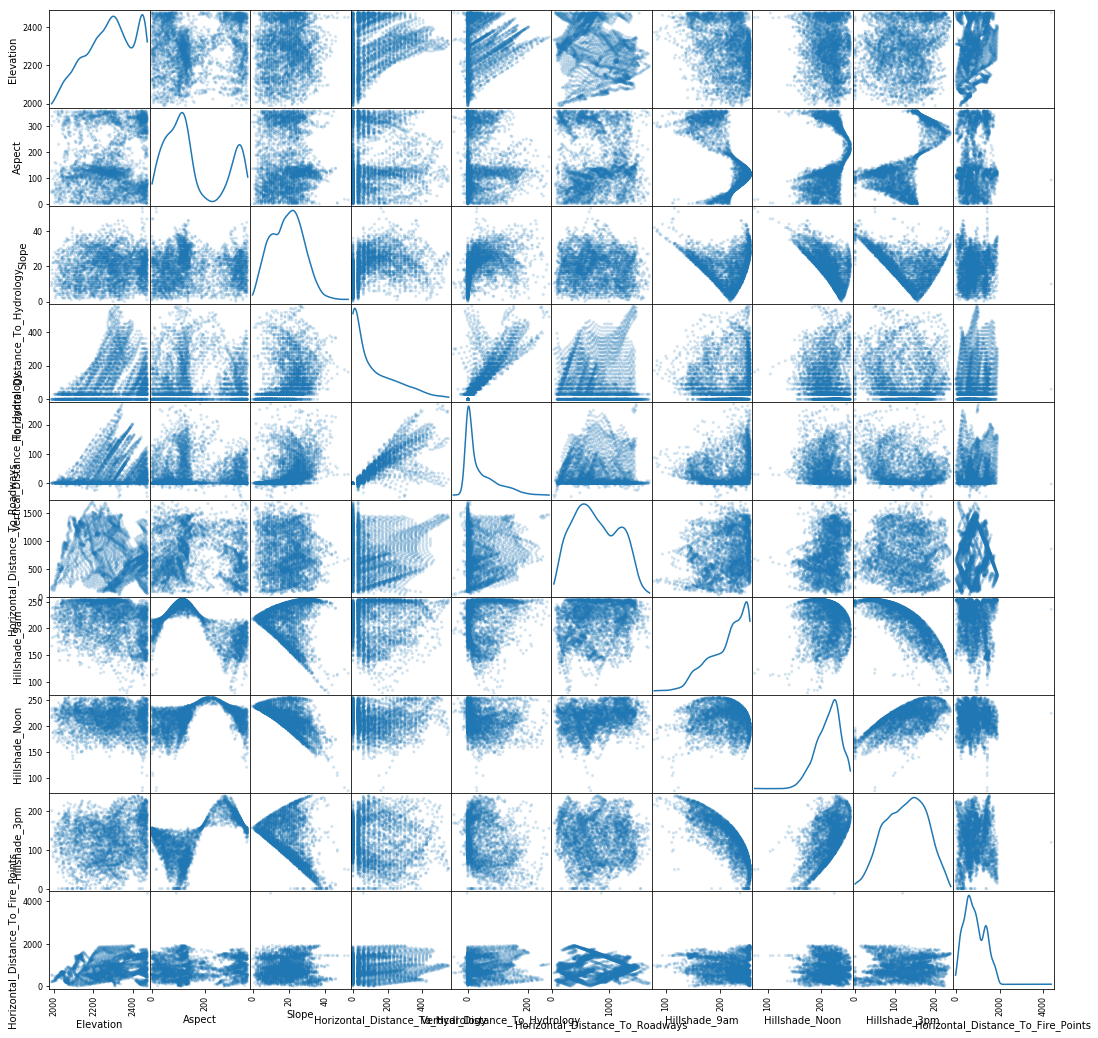

In [33]:
from pandas.plotting import scatter_matrix
scatter_matrix(reduced_data[features], alpha=0.2, figsize=(18, 18), diagonal='kde');

In [73]:
reduced_features = [
 'Elevation',
 'Aspect',
 'Slope',
 'Horizontal_Distance_To_Hydrology',
 'Horizontal_Distance_To_Roadways',
 'Hillshade_9am',
 'Hillshade_Noon',
 'Horizontal_Distance_To_Fire_Points']

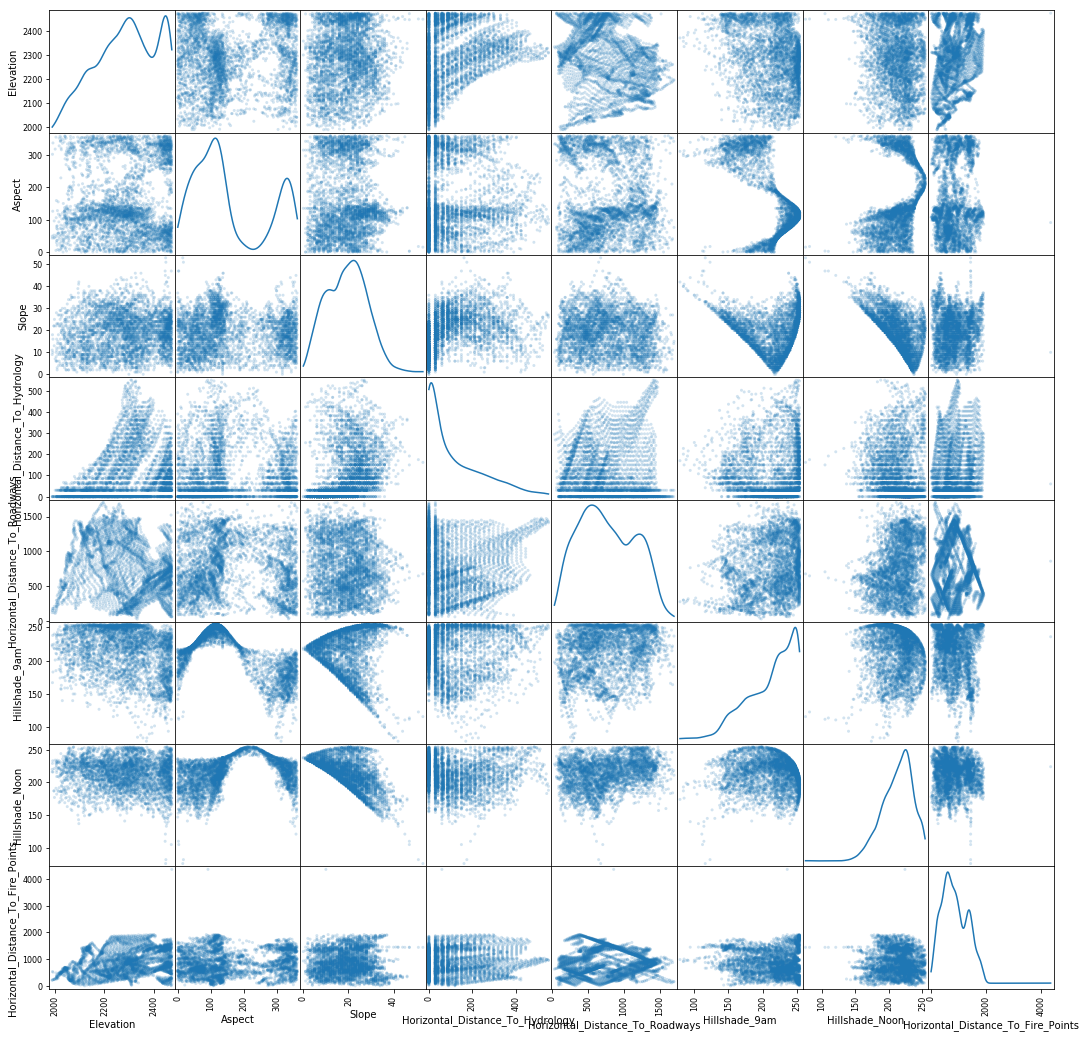

In [35]:
scatter_matrix(reduced_data[reduced_features], alpha=0.2, figsize=(18, 18), diagonal='kde');

## apply PCA

In [59]:
from sklearn.decomposition import PCA
import visuals as vs
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = min_max_scaler.fit_transform(reduced_data[reduced_features])
reduced_data = pd.DataFrame(data_scaled)

In [74]:
reduced_data = reduced_data[reduced_features]
normalized_data=(reduced_data-reduced_data.mean())/reduced_data.std()

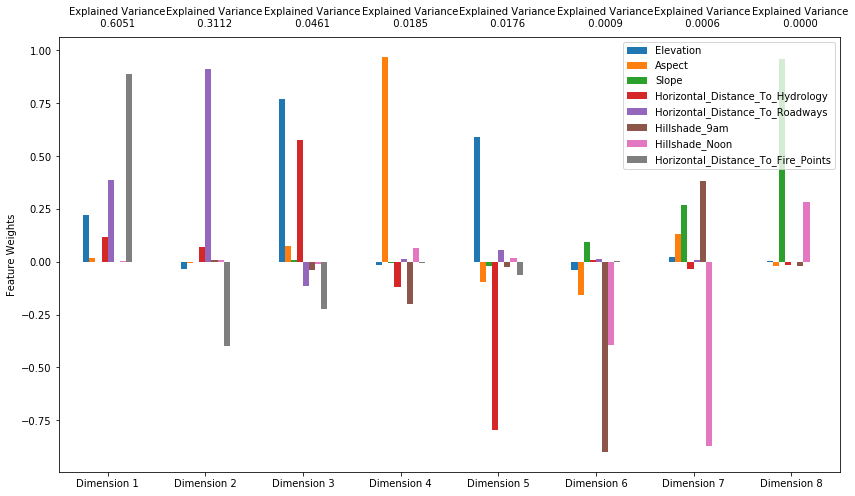

In [75]:
pca = PCA()
pca.fit(reduced_data)
pca_results = vs.pca_results(reduced_data, pca)

## PCA with two dimensions

In [76]:
pca = PCA(n_components=2)
pca.fit(reduced_data)
pca_data = pca.transform(reduced_data)
pca_data = pd.DataFrame(pca_data, columns = ['Dimension 1', 'Dimension 2'])

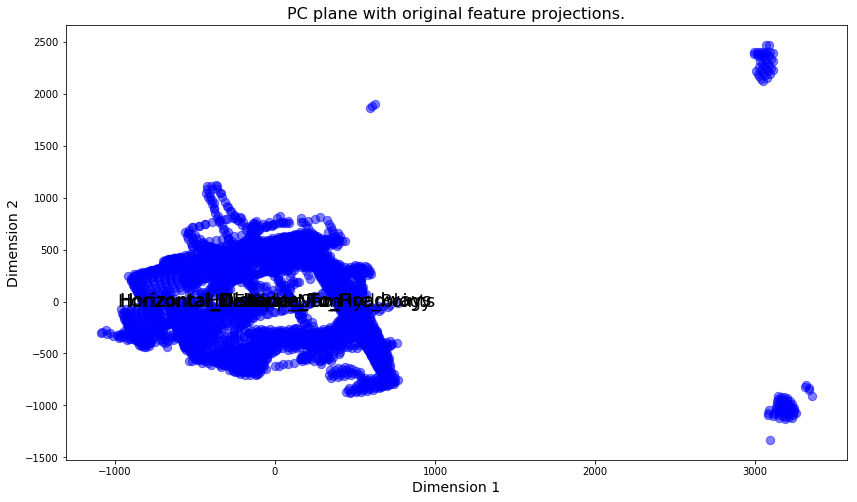

In [77]:
vs.biplot(reduced_data, pca_data, pca);

In [78]:
clusterer = GaussianMixture(n_components=2).fit(pca_data)

In [79]:
preds = clusterer.predict(pca_data)
centers = clusterer.means_
print(centers)

[[ 3135.33840293   303.76607753]
 [  -73.49564303    -7.12059763]]


TypeError: unhashable type

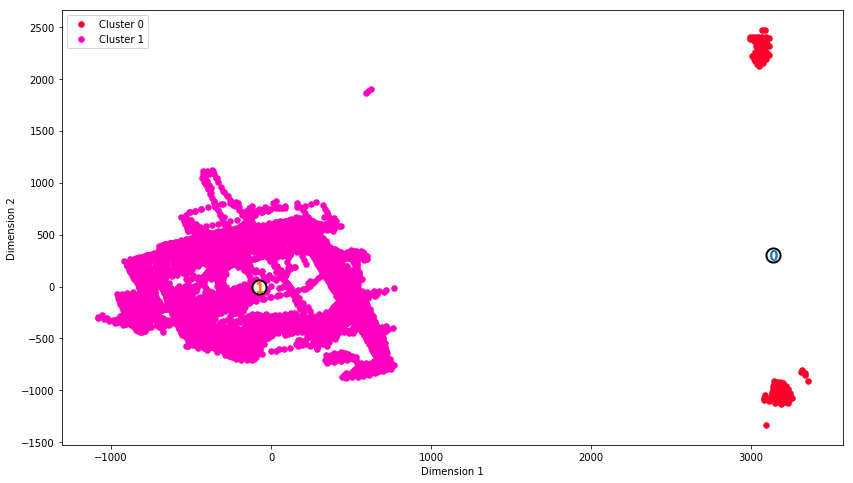

In [80]:
vs.cluster_results(pca_data, preds, centers, reduced_data[:10])